## Getting started

### Trying it out

While we consider pyMOR mainly as a library for building MOR applications, we
ship a few example scripts. These can be found in the `src/pymordemos`
directory of the source repository (some are available as Jupyter notebooks in
the `notebooks` directory). Try launching one of them using the `pymor-demo`
script:

```
pymor-demo thermalblock --plot-err --plot-solutions 3 2 3 32
```

The demo scripts can also be launched directly from the source tree:

```
./thermalblock.py --plot-err --plot-solutions 3 2 3 32
```

This will reduce the so called thermal block problem using the reduced basis
method with a greedy basis generation algorithm. The thermal block problem
consists in solving the stationary heat equation

```
- ∇ ⋅ [ d(x, μ) ∇ u(x, μ) ] = 1     for x in Ω
                  u(x, μ)   = 0     for x in ∂Ω
```

on the domain Ω = [0,1]^2 for the unknown u. The domain is partitioned into
`XBLOCKS x YBLOCKS` blocks (`XBLOCKS` and `YBLOCKS` are the first
two arguments to `thermalblock.py`). The thermal conductivity d(x, μ)
is constant on each block (i,j) with value μ_ij:

```
(0,1)------------------(1,1)
|        |        |        |
|  μ_11  |  μ_12  |  μ_13  |
|        |        |        |
|---------------------------
|        |        |        |
|  μ_21  |  μ_22  |  μ_23  |
|        |        |        |
(0,0)------------------(1,0)
```

The real numbers μ_ij form the `XBLOCKS x YBLOCKS` - dimensional parameter
on which the solution depends.

Running `thermalblock.py` will first produce plots of two detailed
solutions of the problem for different randomly chosen parameters
using linear finite elements. (The size of the grid can be controlled
via the `--grid` parameter. The randomly chosen parameters will
actually be the same for each run, since a the random generator
is initialized with a fixed default seed in
[default_random_state](./generated/pymor.tools.html#pymor.tools.random.default_random_state).)

After closing the window, the reduced basis for model order reduction
is generated using a greedy search algorithm with error estimator.
The third parameter `SNAPSHOTS` of `thermalblock.py` determines how many
different values per parameter component μ_ij should be considered.
I.e. the parameter training set for basis generation will have the
size `SNAPSHOTS^(XBLOCKS x YBLOCKS)`. After the basis of size 32 (the
last parameter) has been computed, the quality of the obtained reduced model
(on the 32-dimensional reduced basis space) is evaluated by comparing the
solutions of the reduced and detailed models for new, randomly chosen
parameter values. Finally, plots of the detailed and reduced solutions, as well
as the difference between the two, are displayed for the random
parameter values which maximises reduction error.

### The thermalblock demo explained

In the following we will walk through the thermal block demo step by
step in an interactive Python shell. We assume that you are familiar
with the reduced basis method and that you know the basics of
[Python](http://www.python.org) programming as well as working
with [NumPy](https://numpy.org/doc/stable/reference/index.html#module-numpy). (Note that our code will differ a bit from
`thermalblock.py` as we will hardcode the various options the script
offers and leave out some features.)

First, start a Python shell. We recommend using
[IPython](http://ipython.org)

```
ipython
```

You can paste the following input lines starting with `>>>` by copying
them to the system clipboard and then executing

```
%paste
```

inside the IPython shell.

First, we will import the most commonly used methods and classes of pyMOR
by executing:

In [1]:
from pymor.basic import *
from pymor.core.logger import set_log_levels
set_log_levels({'pymor.algorithms.greedy': 'ERROR', 'pymor.algorithms.gram_schmidt.gram_schmidt': 'ERROR', 'pymor.algorithms.image.estimate_image_hierarchical': 'ERROR'})

Next we will instantiate a class describing the analytical problem
we want so solve. In this case, a
[thermal_block_problem](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.thermalblock.thermal_block_problem):

In [2]:
p = thermal_block_problem(num_blocks=(3, 2))

We want to discretize this problem using the finite element method.
We could do this by hand, creating a [Grid](./generated/pymor.discretizers.builtin.grids.html#pymor.discretizers.builtin.grids.interfaces.AffineGrid), instatiating
[DiffusionOperatorP1](./generated/pymor.discretizers.builtin.html#pymor.discretizers.builtin.cg.DiffusionOperatorP1) finite element diffusion
operators for each subblock of the domain, forming a [LincombOperator](./generated/pymor.operators.html#pymor.operators.constructions.LincombOperator)
to represent the affine decomposition, instantiating a
[L2ProductFunctionalP1](./generated/pymor.discretizers.builtin.html#pymor.discretizers.builtin.cg.L2ProductFunctionalP1) as right hand side, and
putting it all together into a [StationaryModel](./generated/pymor.models.html#pymor.models.basic.StationaryModel). However, since
[thermal_block_problem](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.thermalblock.thermal_block_problem) returns
a [StationaryProblem](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.elliptic.StationaryProblem), we can use
a predifined *discretizer* to do the work for us. In this case, we use
[discretize_stationary_cg](./generated/pymor.discretizers.builtin.html#pymor.discretizers.builtin.cg.discretize_stationary_cg):

In [3]:
fom, fom_data = discretize_stationary_cg(p, diameter=1./50.)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

`fom` is the [StationaryModel](./generated/pymor.models.html#pymor.models.basic.StationaryModel) which has been created for us,
whereas `fom_data` contains some additional data, in particular the [Grid](./generated/pymor.discretizers.builtin.grids.html#pymor.discretizers.builtin.grids.interfaces.AffineGrid)
and the [BoundaryInfo](./generated/pymor.discretizers.builtin.grids.html#pymor.discretizers.builtin.grids.interfaces.BoundaryInfo) which have been created during discretization. We
can have a look at the grid,

In [4]:
print(fom_data['grid'])

Tria-Grid on domain [0,1] x [0,1]
x0-intervals: 50, x1-intervals: 50
elements: 10000, edges: 15100, vertices: 5101


and, as always, we can display its class documentation using
`help(fom_data['grid'])`.

Let’s solve the thermal block problem and visualize the solution:

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

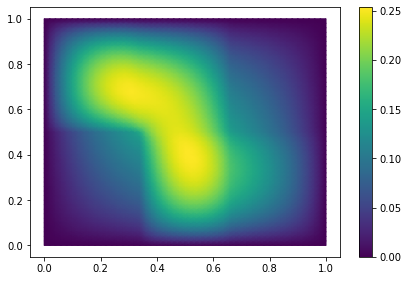

In [5]:
U = fom.solve([1.0, 0.1, 0.3, 0.1, 0.2, 1.0])
fom.visualize(U, title='Solution')

Each class in pyMOR that describes a [Parameter](./generated/pymor.parameters.html#pymor.parameters.base.Parameters)-dependent mathematical
object, like the [StationaryModel](./generated/pymor.models.html#pymor.models.basic.StationaryModel) in our case, derives from
[ParametricObject](./generated/pymor.parameters.html#pymor.parameters.base.ParametricObject). [ParametricObjects](./generated/pymor.parameters.html#pymor.parameters.base.ParametricObject) automatically determine the
[Parameters](./generated/pymor.parameters.html#pymor.parameters.base.Parameters) they depend on from [ParametricObjects](./generated/pymor.parameters.html#pymor.parameters.base.ParametricObject) that have been passed
as `__init__` arguments and from the
[parameters_own](./generated/pymor.parameters.html#pymor.parameters.base.ParametricObject.parameters_own) and
[parameters_internal](./generated/pymor.parameters.html#pymor.parameters.base.ParametricObject.parameters_internal)
attributes that have been set in `__init__`.
Let’s have a look:

In [6]:
print(fom.parameters)

{diffusion: 6}


This tells us, that the [Parameters](./generated/pymor.parameters.html#pymor.parameters.base.Parameters) which
[solve](./generated/pymor.models.html#pymor.models.interface.Model.solve) expects
should be a dictionary with one key `'diffusion'` whose value is a one-dimensional
[NumPy array](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html#numpy.ndarray) of size `6`, corresponding to the block structure of
the problem. However, as an exception to this rule, the interface methods of
[Models](./generated/pymor.models.html#pymor.models.interface.Model) allow simply passing the list `[1.0, 0.1, 0.3, 0.1, 0.2, 1.0]` by
internally calling `parse`.

Next we want to use the [greedy](./generated/pymor.algorithms.html#pymor.algorithms.greedy.greedy) algorithm
to reduce the problem. For this we need to choose a reductor which will keep
track of the reduced basis and perform the actual RB-projection. We will use
[CoerciveRBReductor](./generated/pymor.reductors.html#pymor.reductors.coercive.CoerciveRBReductor), which will
also assemble an error estimator to estimate the reduction error. This
will significantly speed up the basis generation, as we will only need to
solve the high-dimensional problem for those parameters in the training set
which are actually selected for basis extension. To control the condition of
the reduced system matrix, we must ensure that the generated basis is
orthonormal w.r.t. the H1_0-product on the solution space. For this we pass
the `h1_0_semi_product` attribute of the model as inner product to
the reductor, which will also use it for computing the Riesz representatives
required for error estimation. Moreover, we have to provide
the reductor with a [ParameterFunctional](./generated/pymor.parameters.html#pymor.parameters.functionals.ParameterFunctional) which computes a lower bound for
the coercivity of the problem for given [parameter values](./generated/pymor.parameters.html#pymor.parameters.base.Mu).

In [7]:
reductor = CoerciveRBReductor(
    fom,
    product=fom.h1_0_semi_product,
    coercivity_estimator=ExpressionParameterFunctional('min(diffusion)', fom.parameters)
)

Moreover, we need to select a training set of [parameter values](./generated/pymor.parameters.html#pymor.parameters.base.Mu). The problem
`p` already comes with a [ParameterSpace](./generated/pymor.parameters.html#pymor.parameters.base.ParameterSpace), from which we can easily sample
these values.  E.g.:

In [8]:
training_set = p.parameter_space.sample_uniformly(4)
print(training_set[0])

{diffusion: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]}


Now we start the basis generation:

In [9]:
greedy_data = rb_greedy(fom, reductor, training_set, max_extensions=32)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

The `max_extensions` parameter defines how many basis vectors we want to
obtain. `greedy_data` is a dictionary containing various data that has
been generated during the run of the algorithm:

In [10]:
print(greedy_data.keys())

dict_keys(['max_errs', 'max_err_mus', 'extensions', 'time', 'rom'])


The most important items is `'rom'` which holds the reduced [Model](./generated/pymor.models.html#pymor.models.interface.Model)
obtained from applying our reductor with the final reduced basis.

In [11]:
rom = greedy_data['rom']

All vectors in pyMOR are stored in so called [VectorArrays](./generated/pymor.vectorarrays.html#pymor.vectorarrays.interface.VectorArray). For example
the solution `U` computed above is given as a [VectorArray](./generated/pymor.vectorarrays.html#pymor.vectorarrays.interface.VectorArray) of length 1.
For the reduced basis we have:

In [12]:
RB = reductor.bases['RB']
print(type(RB))
print(len(RB))
print(RB.dim)

<class 'pymor.vectorarrays.numpy.NumpyVectorArray'>
32
5101


Let us check if the reduced basis really is orthonormal with respect to
the H1-product. For this we use the [apply2](./generated/pymor.operators.html#pymor.operators.interface.Operator.apply2)
method:

In [13]:
import numpy as np
gram_matrix = RB.gramian(fom.h1_0_semi_product)
print(np.max(np.abs(gram_matrix - np.eye(32))))

2.4302825377131576e-14


Looks good! We can now solve the reduced model for the same [parameter values](./generated/pymor.parameters.html#pymor.parameters.base.Mu)
as above.  The result is a vector of coefficients w.r.t. the reduced basis, which is
currently stored in `RB`. To form the linear combination, we can use the
`reconstruct` method of the reductor:

In [14]:
u = rom.solve([1.0, 0.1, 0.3, 0.1, 0.2, 1.0])
print(u)
U_red = reductor.reconstruct(u)
print(U_red.dim)

[[ 0.56008169  0.19410562  0.00463453  0.01675562  0.04900982  0.07760119
  -0.08043888 -0.02889488 -0.03121126  0.26467367  0.13991773 -0.09805741
   0.16005484  0.04417512 -0.05245844 -0.00132281 -0.01304436  0.01330245
  -0.02185056  0.00625769 -0.00868736 -0.00115484  0.01895446 -0.00153234
   0.02306277  0.0035532   0.01061803 -0.00225572  0.00199581 -0.0068476
   0.00186538  0.0047302 ]]
5101


Finally we compute the reduction error and display the reduced solution along with
the detailed solution and the error:

[0.00480011]


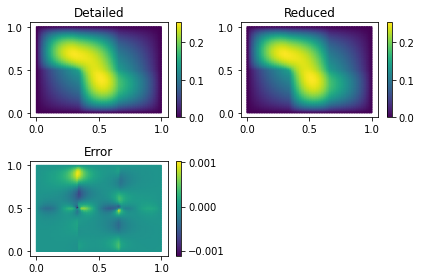

In [15]:
ERR = U - U_red
print(ERR.norm(fom.h1_0_semi_product))
fom.visualize((U, U_red, ERR),
              legend=('Detailed', 'Reduced', 'Error'),
              separate_colorbars=True)

We can nicely observe that, as expected, the error is maximized along the
jumps of the diffusion coefficient.

# Learning more

As a next step, you should read our [Technical Overview](./technical_overview.html#technical-overview) which discusses the
most important concepts and design decisions behind pyMOR. You can also follow our
growing set of tutorials which focus on specific aspects of pyMOR.

Should you have any problems regarding pyMOR, questions or
[feature requests](https://github.com/pymor/pymor/issues), do not hesitate
to contact us at our
[mailing list](http://listserv.uni-muenster.de/mailman/listinfo/pymor-dev)!